#### Github: https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/blob/main/Algorithmic_Trading_Machine_Learning_Quant_Strategies.ipynb

### 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import requests
warnings.filterwarnings('ignore')
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content

# Lire les tables depuis le HTML
sp500 = pd.read_html(html)[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(symbols_list, start=start_date, end=end_date)

#Changer 'Price' par ''
levels = df.columns.levels
new_names = ['', 'Ticker']
new_index = pd.MultiIndex(
    levels=levels,
    codes=df.columns.codes,
    names=new_names)
df.columns = new_index

df = df.stack(level=1)
df.index.names = ['date','ticker']
df.columns=df.columns.str.lower()


[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
['BEN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27)')
['GEV', 'VLTO', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


### 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

$$\text{Garman-Klass Volatility}= \frac{(\ln(\text{High})-\ln(\text{Low}))^2}{2}-(2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{Open}))^2$$

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low']= df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_art(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['adj close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_art)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd']=df.groupby(level=1,group_keys=False)['adj close'].apply(compute_macd)

#WE DON'T NORMALIZE THE RSI 

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high  \
date                      ticker                                       
2015-09-29 00:00:00+00:00 A        31.425230   33.740002   34.060001   
                          AAL      37.361610   39.180000   39.770000   
                          AAPL     24.622625   27.264999   28.377501   
                          ABBV     36.004166   52.790001   54.189999   
                          ABT      33.302036   39.500000   40.150002   
...                                      ...         ...         ...   
2023-09-26 00:00:00+00:00 XYL      88.501106   89.519997   90.849998   
                          YUM     121.604248  124.010002  124.739998   
                          ZBH     111.534821  112.459999  117.110001   
                          ZBRA    223.960007  223.960007  226.649994   
                          ZTS     175.131149  176.869995  178.449997   

                                         low        open       volume  \
date                      ticker                                        
2015-09-29 00:00:00+00:00 A        33.240002   33.360001    2252400.0   
                          AAL      38.790001   39.049999    7478800.0   
                          AAPL     26.965000   28.207500  293461600.0   
                          ABBV     51.880001   53.099998   12842800.0   
                          ABT      39.029999   39.259998   12287500.0   
...                                      ...         ...          ...   
2023-09-26 00:00:00+00:00 XYL      89.500000   90.379997    1322400.0   
                          YUM     123.449997  124.239998    1500600.0   
                          ZBH     112.419998  116.769997    3610500.0   
                          ZBRA    222.580002  225.970001     355400.0   
                          ZTS     176.270004  176.580002    1463200.0   

                                  garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2015-09-29 00:00:00+00:00 A              -0.001082        NaN       NaN   
                          AAL            -0.000443        NaN       NaN   
                          AAPL           -0.005833        NaN       NaN   
                          ABBV           -0.057368        NaN       NaN   
                          ABT            -0.010064        NaN       NaN   
...                                            ...        ...       ...   
2023-09-26 00:00:00+00:00 XYL            -0.000058  26.146748  4.483137   
                          YUM            -0.000124  36.057142  4.806770   
                          ZBH             0.000022  31.893235  4.745884   
                          ZBRA            0.000133  29.494977  5.400991   
                          ZTS             0.000049  42.623493  5.153746   

                                    bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2015-09-29 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAL          NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2023-09-26 00:00:00+00:00 XYL     4.565058  4.646979 -3.003733 -2.159188   
                          YUM     4.836734  4.866698 -2.859871 -1.363696   
                          ZBH     4.785551  4.825217 -2.109952 -0.881067   
                          ZBRA    5.539167  5.677342 -0.057389 -1.600791   
                          ZTS     5.212559  5.271371 -0.695658 -1.188278   

                                  dollar_volume  
date                      ticker                 
2015-09-29 00:00:00+00:00 A           70.782188  
                          AAL    

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open','high','low','close']]
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack('ticker')[last_cols].resample('M').last().stack()],axis=1).dropna()


In [4]:
data['dollar_volume'] = data.unstack()['dollar_volume'].rolling(5*12, min_periods=12).mean().stack()
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis=1)

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2016-10-31 00:00:00+00:00 AAL      39.134327         -0.000176  62.203532   
                          AAPL     26.182171         -0.002541  49.891106   
                          ABBV     39.878788         -0.049190  27.477781   
                          ABT      34.112480         -0.008074  38.008837   
                          ACN     103.117393         -0.005023  53.823647   
...                                      ...               ...        ...   
2023-09-30 00:00:00+00:00 XOM     112.466652         -0.000205  59.440192   
                          MRNA     98.120003          0.000146  38.747314   
                          UBER     44.270000          0.000441  45.005268   
                          CRWD    160.479996          0.000144  51.534803   
                          ABNB    132.279999          0.000213  44.494127   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAL     3.604673  3.655494  3.706314  1.161163   
                          AAPL    3.293123  3.322002  3.350880 -0.978402   
                          ABBV    3.744517  3.798670  3.852823  0.194826   
                          ABT     3.549492  3.599959  3.650426 -0.633574   
                          ACN     4.633009  4.644646  4.656283  0.061475   
...                                    ...       ...       ...       ...   
2023-09-30 00:00:00+00:00 XOM     4.679146  4.719239  4.759332 -1.303970   
                          MRNA    4.582514  4.685332  4.788149 -0.529511   
                          UBER    3.806654  3.862227  3.917801 -0.746098   
                          CRWD    5.026187  5.103696  5.181204 -0.744862   
                          ABNB    4.857047  4.940924  5.024801 -1.006939   

                                      macd  
date                      ticker            
2016-10-31 00:00:00+00:00 AAL     1.131595  
                          AAPL   -0.195978  
                          ABBV   -0.760594  
                          ABT    -0.650888  
                          ACN    -0.135456  
...                                    ...  
2023-09-30 00:00:00+00:00 XOM     1.400623  
                          MRNA   -0.376899  
                          UBER   -0.133973  
                          CRWD    0.245950  
                          ABNB   -0.037854  

[12516 rows x 8 columns]

### 4. Calculate Monthly Returns for different time horizons as features.

In [5]:
# g = df.xs('AAPL',level=1)
def calculate_returns(df):
    lags = [1, 2, 3, 6, 9, 12]
    outlier_cutoff = 0.005
    for lag in lags:
        df[f"return_{lag}m"] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
data = data.groupby(level=1,group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2017-10-31 00:00:00+00:00 AAL      45.534168         -0.000363  41.051789   
                          AAPL     39.667980         -0.001105  69.196710   
                          ABBV     66.876801         -0.036142  55.247860   
                          ABT      48.237465         -0.005677  53.844903   
                          ACN     128.834671         -0.004274  69.365149   
...                                      ...               ...        ...   
2023-09-30 00:00:00+00:00 XOM     112.466652         -0.000205  59.440192   
                          MRNA     98.120003          0.000146  38.747314   
                          UBER     44.270000          0.000441  45.005268   
                          CRWD    160.479996          0.000144  51.534803   
                          ABNB    132.279999          0.000213  44.494127   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2017-10-31 00:00:00+00:00 AAL     3.849110  3.921750  3.994389  1.125076   
                          AAPL    3.593605  3.640476  3.687347 -0.544507   
                          ABBV    4.187696  4.234050  4.280405  1.610789   
                          ABT     3.887385  3.910952  3.934519 -0.122964   
                          ACN     4.798335  4.838013  4.877691  0.133203   
...                                    ...       ...       ...       ...   
2023-09-30 00:00:00+00:00 XOM     4.679146  4.719239  4.759332 -1.303970   
                          MRNA    4.582514  4.685332  4.788149 -0.529511   
                          UBER    3.806654  3.862227  3.917801 -0.746098   
                          CRWD    5.026187  5.103696  5.181204 -0.744862   
                          ABNB    4.857047  4.940924  5.024801 -1.006939   

                                      macd  return_1m  return_2m  return_3m  \
date                      ticker                                              
2017-10-31 00:00:00+00:00 AAL    -0.018698  -0.014108   0.022981  -0.023860   
                          AAPL   -0.039276   0.096807   0.015250   0.044955   
                          ABBV    0.473814   0.022728   0.098590   0.091379   
                          ABT     0.276133   0.021276   0.034308   0.034801   
                          ACN     0.352342   0.064180   0.048454   0.037202   
...                                    ...        ...        ...        ...   
2023-09-30 00:00:00+00:00 XOM     1.400623   0.046947   0.046139   0.030496   
                          MRNA   -0.376899  -0.132219  -0.086803  -0.068763   
                          UBER   -0.133973  -0.062672  -0.053920   0.008422   
                          CRWD    0.245950  -0.015641  -0.003656   0.029981   
                          ABNB   -0.037854   0.005549  -0.067704   0.010603   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2017-10-31 00:00:00+00:00 AAL      0.016495   0.007008    0.012702  
                          AAPL     0.028875   0.038941    0.035228  
                          ABBV     0.056495   0.047273    0.044026  
                          ABT      0.038672   0.031320    0.029294  
                          ACN      0.028692   0.027398    0.018728  
...                                     ...        ...         ...  
2023-09-30 00:00:00+00:00 XOM      0.012838   0.008747    0.027037  
                          MRNA    -0.071952  -0.064976   -0.015431  
                          UBER     0.057244   0.066838    0.043691  
                          CRWD     0.026391   0.047942   -0.002216  
                          ABNB     0.010289   0.049124    0.019401  

[10341 rows x 14 columns]

In [6]:
data = data.unstack('ticker')
data.index = data.index.tz_localize(None)
data = data.stack()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051789  3.849110   
           AAPL     39.667980         -0.001105  69.196710  3.593605   
           ABBV     66.876801         -0.036142  55.247860  4.187696   
           ABT      48.237465         -0.005677  53.844903  3.887385   
           ACN     128.834671         -0.004274  69.365149  4.798335   
...                       ...               ...        ...       ...   
2023-09-30 VRTX    351.690002          0.000037  52.406728  5.838959   
           VZ       30.755375         -0.001680  42.222499  3.451862   
           WFC      39.479488         -0.000317  40.920290  3.689633   
           WMT      53.445198         -0.000074  54.722532  3.982182   
           XOM     112.466652         -0.000205  59.440192  4.679146   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.125076 -0.018698  -0.014108   
           AAPL    3.640476  3.687347 -0.544507 -0.039276   0.096807   
           ABBV    4.234050  4.280405  1.610789  0.473814   0.022728   
           ABT     3.910952  3.934519 -0.122964  0.276133   0.021276   
           ACN     4.838013  4.877691  0.133203  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907   0.009617   
           VZ      3.484054  3.516245 -2.269785 -0.350386  -0.056889   
           WFC     3.729990  3.770346 -1.480986 -0.282325  -0.015500   
           WMT     3.999651  4.017120 -2.595187  0.399459  -0.000676   
           XOM     4.719239  4.759332 -1.303970  1.400623   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10341 rows x 14 columns]

In [7]:
data.xs('AAPL',level=1)['return_1m'].to_frame()

,return_1m
date,
2017-10-31,0.096807
2017-11-30,0.020278
2017-12-31,-0.015246
2018-01-31,-0.010636
2018-02-28,0.068185
...,...
2023-05-31,0.046058
2023-06-30,0.094330
2023-07-31,0.012786


### 5. Download Fama-French Factors and Calculate Rolling Factor Betas.


In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m'])
factor_data = factor_data.sort_index(level=0) 

In [9]:
observations = factor_data.groupby('ticker').size()
valid_stocks = observations[observations > 10]
factor_data = factor_data[factor_data.index.get_level_values(1).isin(valid_stocks.index)]
factor_data.xs('AAPL',level=1)

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0019,0.0091,-0.0326,0.096807
2017-11-30,0.0312,-0.0032,-0.0003,0.0319,-0.0006,0.020278
2017-12-31,0.0106,-0.0106,0.0006,0.0075,0.0170,-0.015246
2018-01-31,0.0557,-0.0317,-0.0128,-0.0075,-0.0091,-0.010636
2018-02-28,-0.0365,0.0032,-0.0104,0.0048,-0.0228,0.068185
...,...,...,...,...,...,...
2023-05-31,0.0035,-0.0038,-0.0774,-0.0182,-0.0720,0.046058
2023-06-30,0.0647,0.0136,-0.0020,0.0227,-0.0162,0.094330
2023-07-31,0.0321,0.0284,0.0411,-0.0057,0.0062,0.012786


In [10]:
# import pickle

# # Sauvegarde de la variable data dans un fichier
# with open('data.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [11]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns))
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456337 -0.440101 -0.315507 -0.079740  0.800296
           VZ      0.329037 -0.163594  0.272320  0.320802  0.096977
           WFC     1.112946  0.306861  2.044025 -0.451834 -1.511410
           WMT     0.703224 -0.309990 -0.427582 -0.156628  0.526793
           XOM     0.972448 -1.081442  1.740416 -0.634738 -0.371117

[10294 rows x 5 columns]

In [12]:
data = data.join(betas.groupby(level=1).shift()) 
factors = ['Mkt-RF','SMB', 'HML','RMW','CMA']
data.loc[:,factors]=data.groupby(level=1,group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close',axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10101 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10101 non-null  float64
 1   rsi               10101 non-null  float64
 2   bb_low            10101 non-null  float64
 3   bb_mid            10101 non-null  float64
 4   bb_high           10101 non-null  float64
 5   atr               10101 non-null  float64
 6   macd              10101 non-null  float64
 7   return_1m         10101 non-null  float64
 8   return_2m         10101 non-null  float64
 9   return_3m         10101 non-null  float64
 10  return_6m         10101 non-null  float64
 11  return_9m         10101 non-null  float64
 12  return_12m        10101 non-null  float64
 13  Mkt-RF            10101 non-null  float64
 14  SMB               10101 non-null  float64
 15  HML        

### Le dataset data est prêt pour le ML (entrainement) !!!

In [13]:

from sklearn.cluster import KMeans
# data = data.drop('cluster',axis=1)  
target_rsi_values = [30,40,55,70]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:,6]=target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0, 
                           init=initial_centroids).fit(df).labels_
    return df
data = data.dropna().groupby(level=0,group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051789  3.849110  3.921750  3.994389   
           AAPL           -0.001105  69.196710  3.593605  3.640476  3.687347   
           ABBV           -0.036142  55.247860  4.187696  4.234050  4.280405   
           ABT            -0.005677  53.844903  3.887385  3.910952  3.934519   
           ACN            -0.004274  69.365149  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 VRTX            0.000037  52.406728  5.838959  5.859127  5.879295   
           VZ             -0.001680  42.222499  3.451862  3.484054  3.516245   
           WFC            -0.000317  40.920290  3.689633  3.729990  3.770346   
           WMT            -0.000074  54.722532  3.982182  3.999651  4.017120   
           XOM            -0.000205  59.440192  4.679146  4.719239  4.759332   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.125076 -0.018698  -0.014108   0.022981  -0.023860   
           AAPL   -0.544507 -0.039276   0.096807   0.015250   0.044955   
           ABBV    1.610789  0.473814   0.022728   0.098590   0.091379   
           ABT    -0.122964  0.276133   0.021276   0.034308   0.034801   
           ACN     0.133203  0.352342   0.064180   0.048454   0.037202   
...                     ...       ...        ...        ...        ...   
2023-09-30 VRTX    0.029799  0.027907   0.009617  -0.000923  -0.000208   
           VZ     -2.269785 -0.350386  -0.056889  -0.016122  -0.033458   
           WFC    -1.480986 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -2.595187  0.399459  -0.000676   0.010014   0.012354   
           XOM    -1.303970  1.400623   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.264401  1.319622   
           AAPL     0.028875   0.038941    0.035228  1.276809 -0.274814   
           ABBV     0.056495   0.047273    0.044026  0.499080  0.359310   
           ABT      0.038672   0.031320    0.029294  0.829184 -0.188544   
           ACN      0.028692   0.027398    0.018728  1.197552 -0.163035   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.505317 -0.403802   
           VZ      -0.021495  -0.014100   -0.006158  0.298455 -0.208824   
           WFC      0.016712   0.000702    0.003255  1.130268  0.322855   
           WMT      0.017574   0.016553    0.020256  0.743593 -0.256719   
           XOM      0.012838   0.008747    0.027037  0.996161 -1.039316   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.598355  0.471009  0.555049        0  
           AAPL   -0.585546  0.639678  0.443301        2  
           ABBV   -0.032822  0.212862  0.172832        3  
           ABT    -0.540948  0.257527  0.978613        3  
           ACN    -0.326805  0.271914  0.164495        2  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.484808  0.057476  0.946543        2  
           VZ      0.347708  0.328055 -0.007854        3  
           WFC     1.988389 -0.416301 -1.457797        3  
           WMT    -0.535740 -0.139709  0.661319        2  
           XOM     1.691439 -0.669415 -0.285606        1  

[10101 rows x 19 columns]

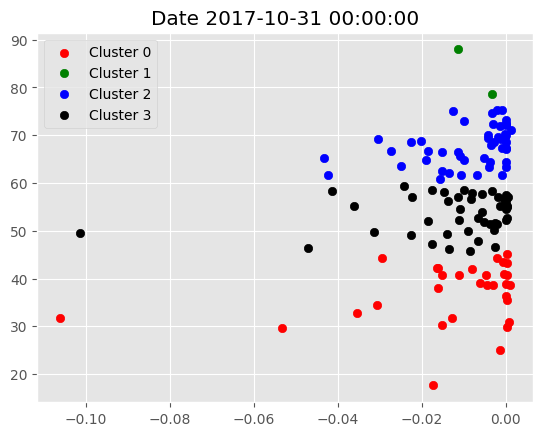

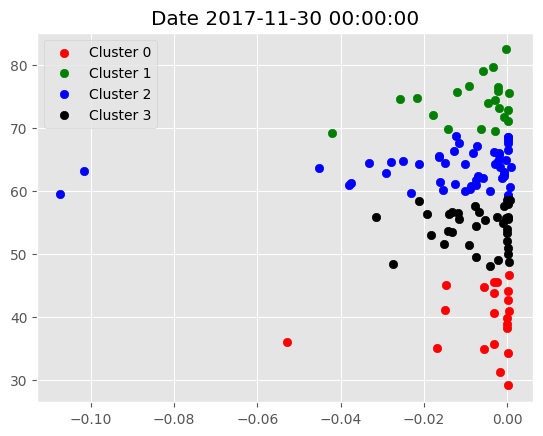

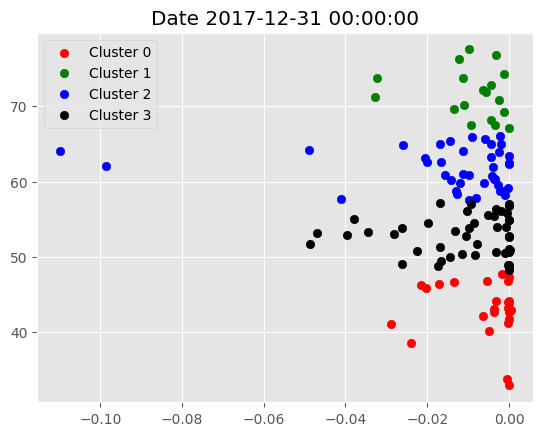

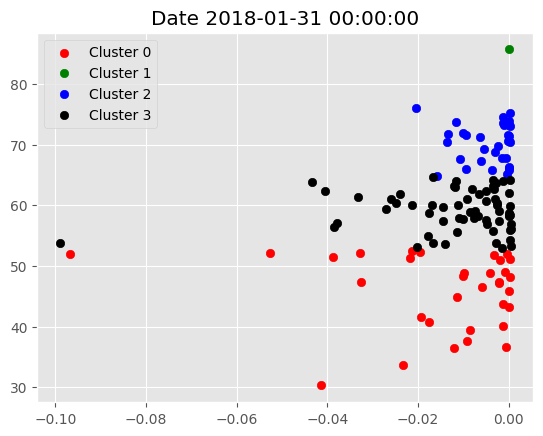

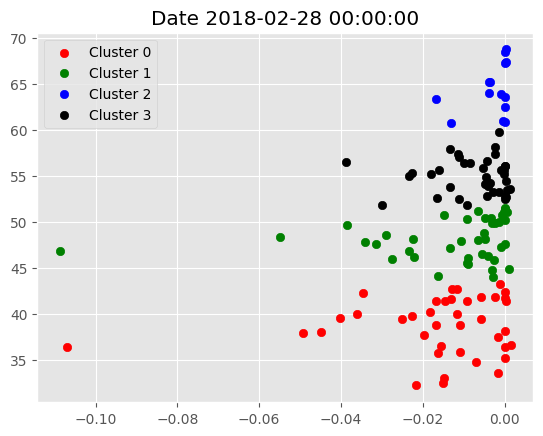

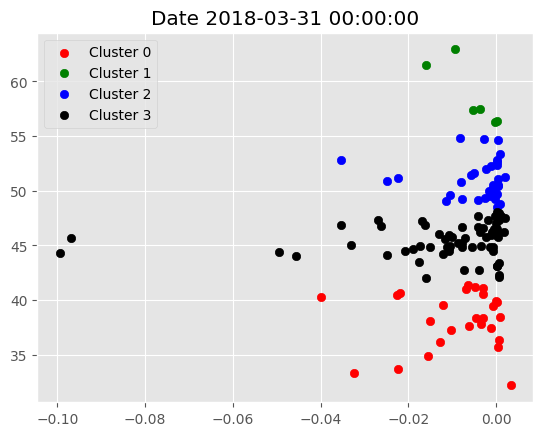

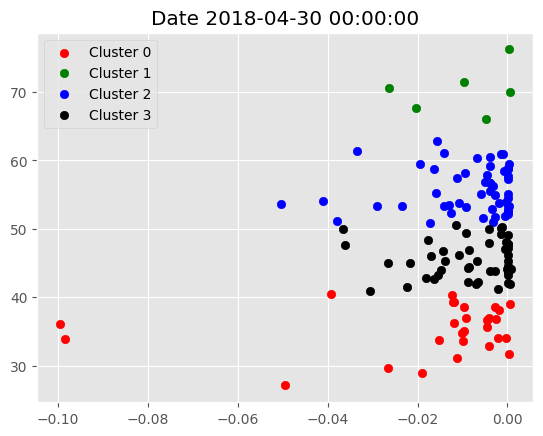

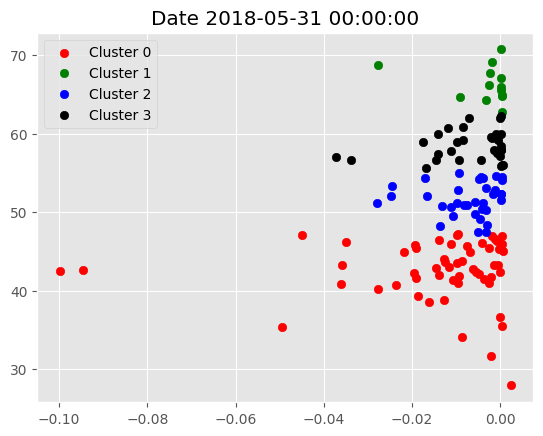

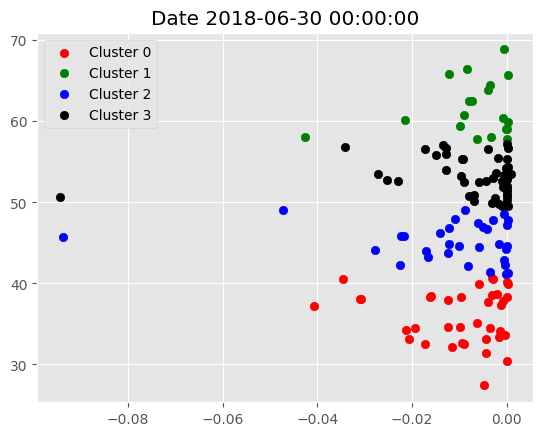

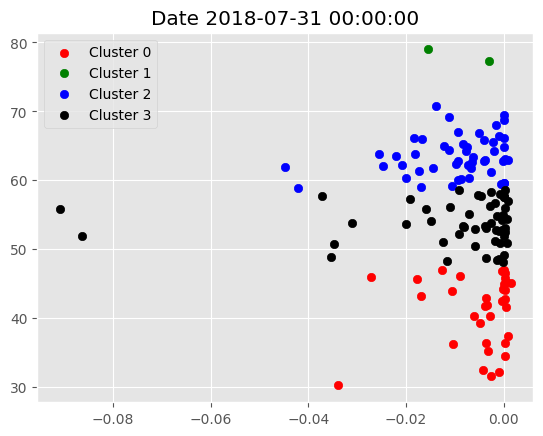

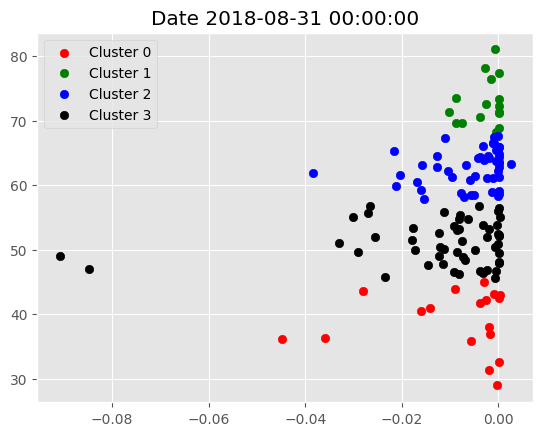

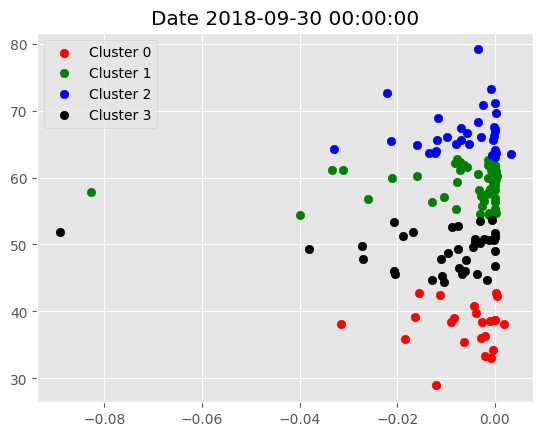

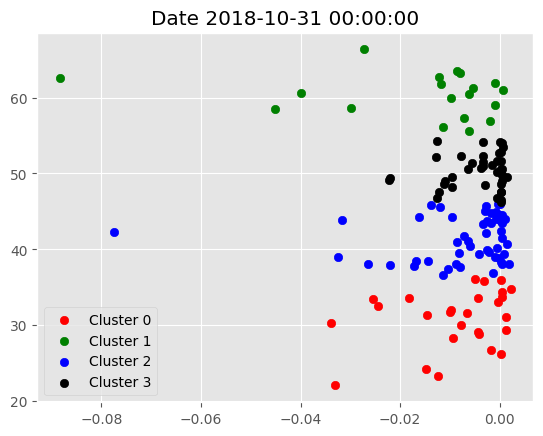

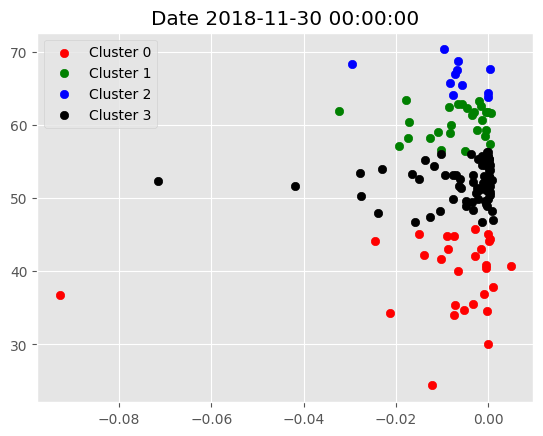

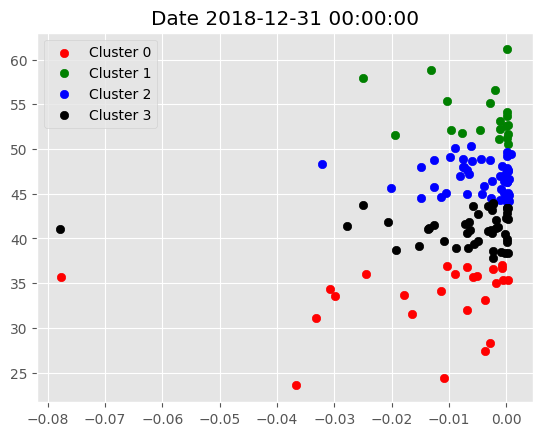

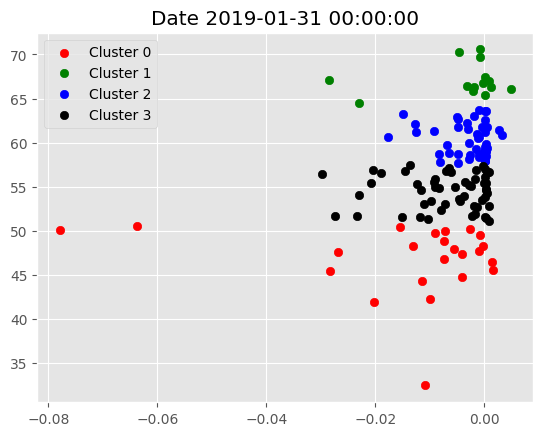

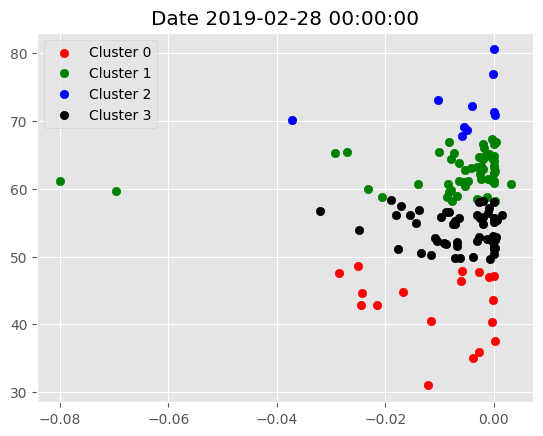

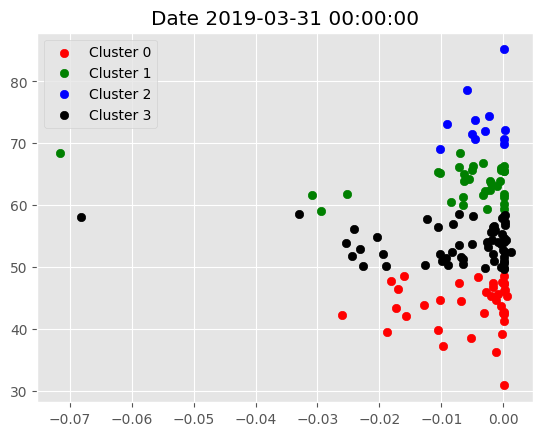

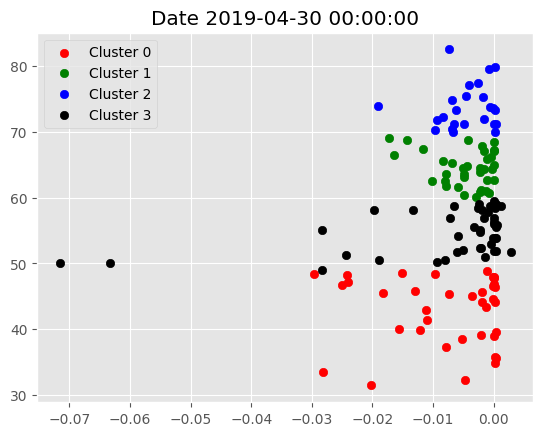

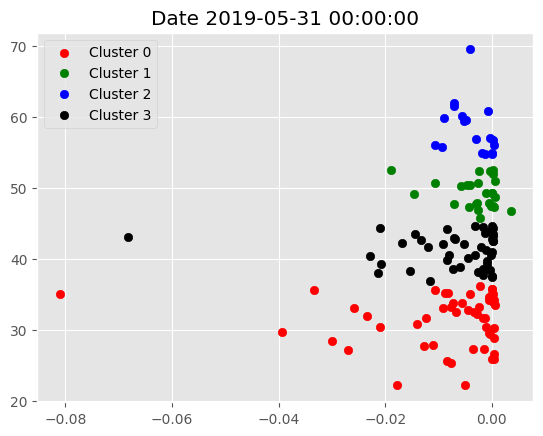

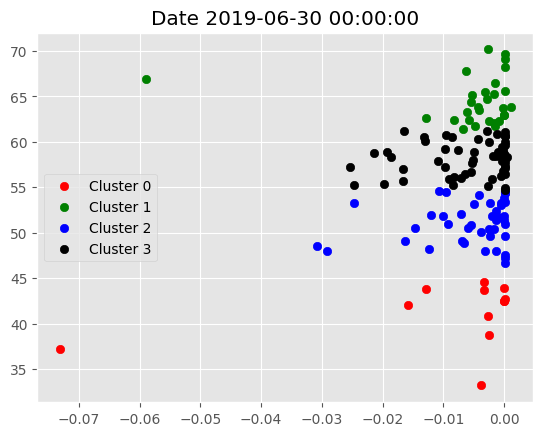

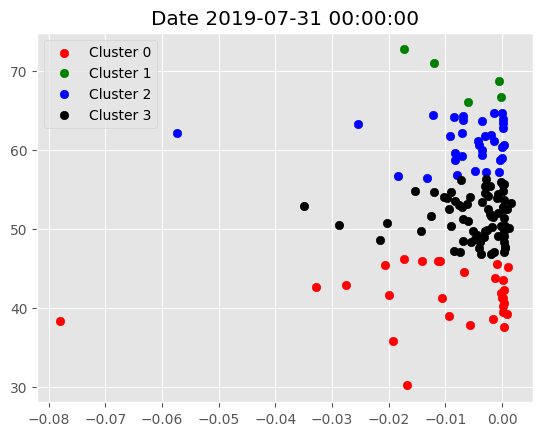

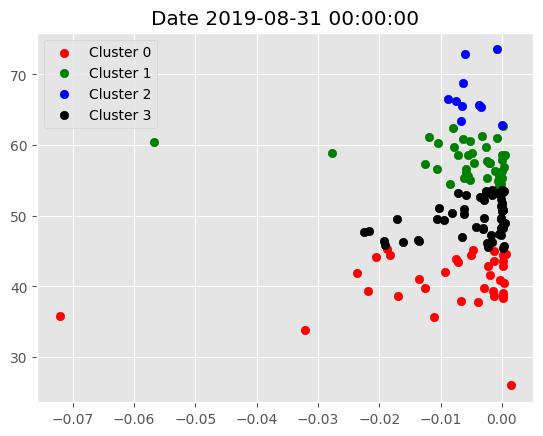

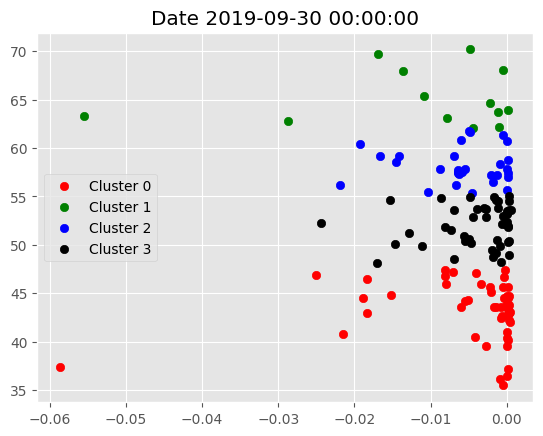

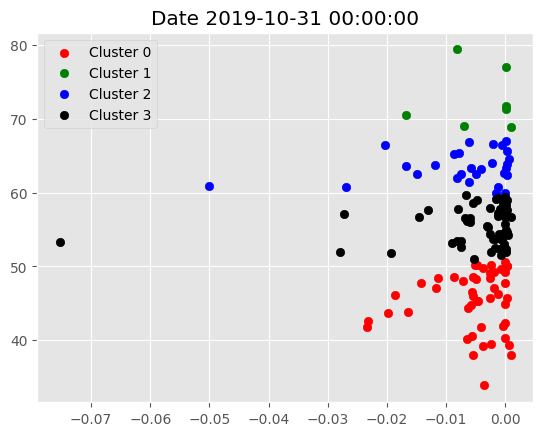

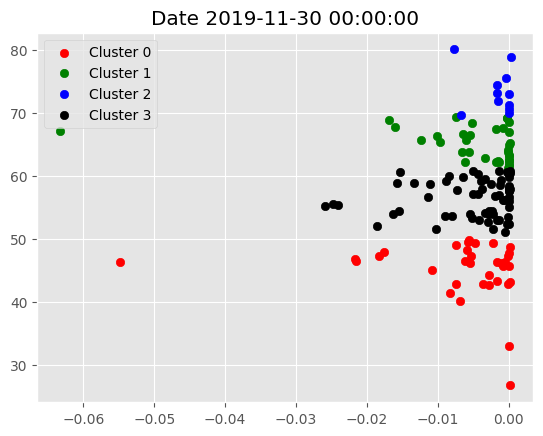

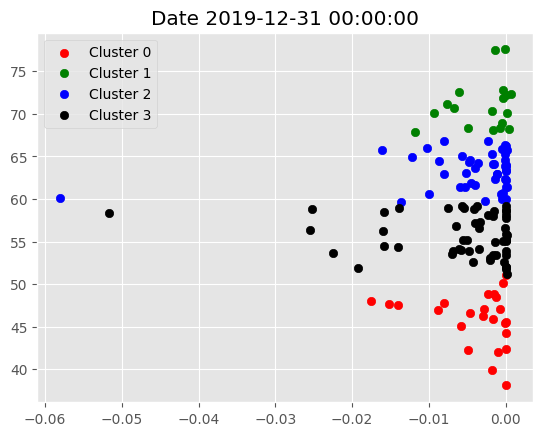

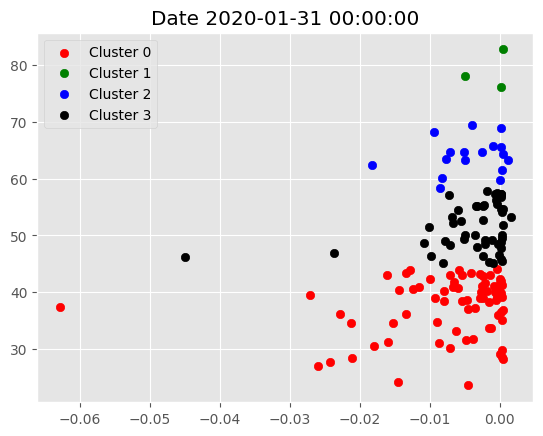

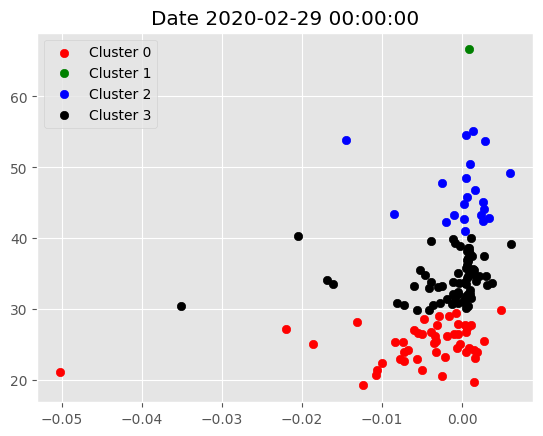

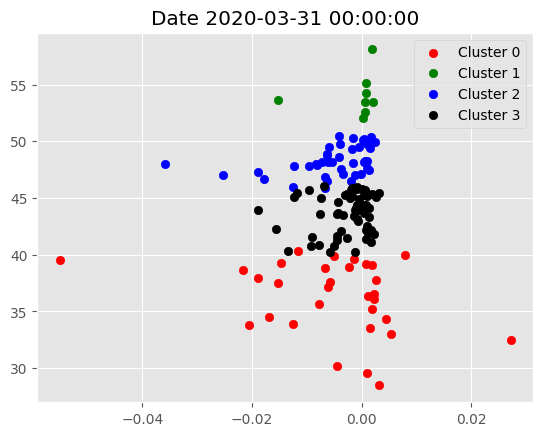

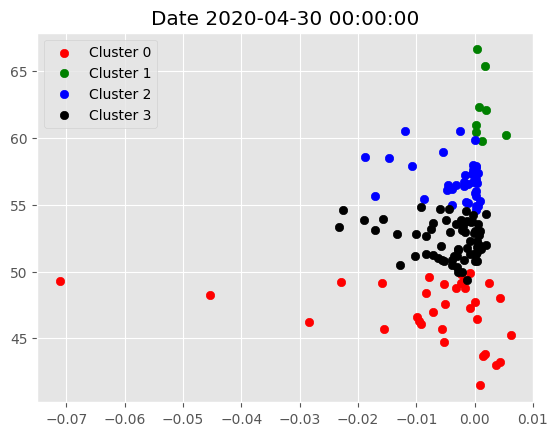

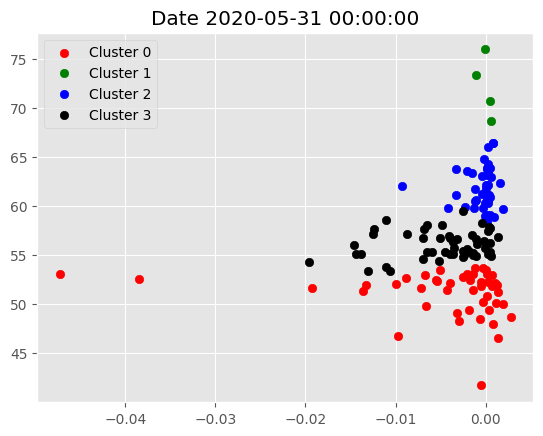

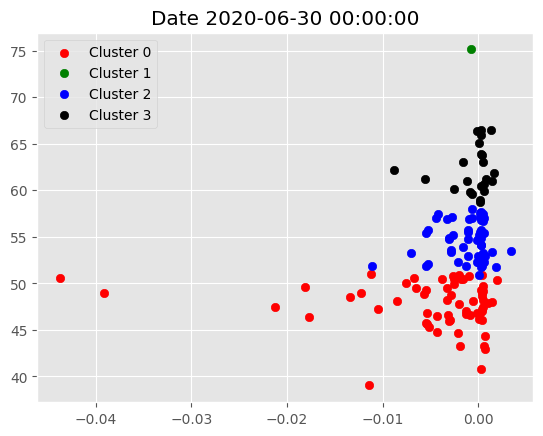

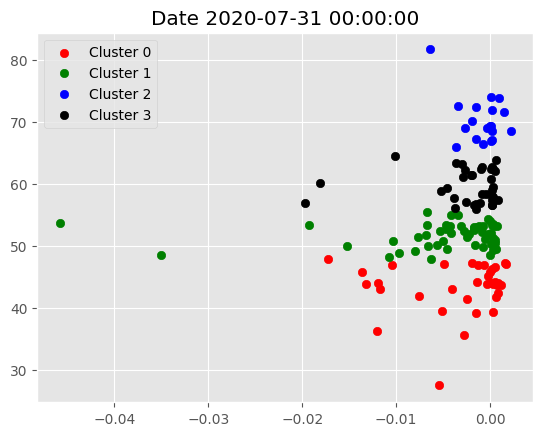

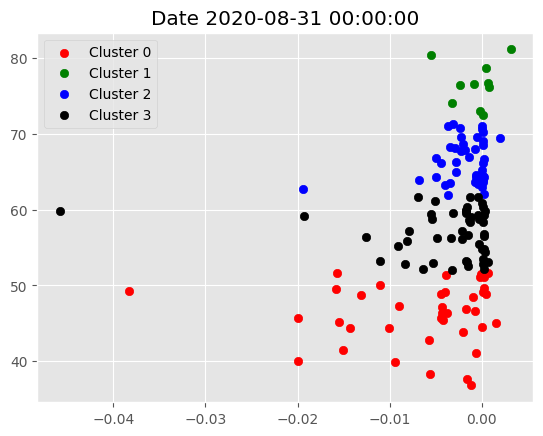

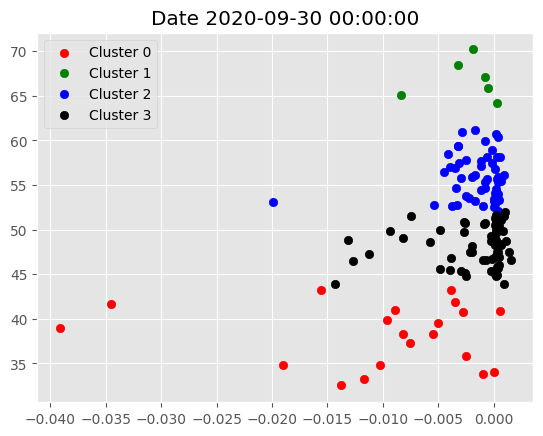

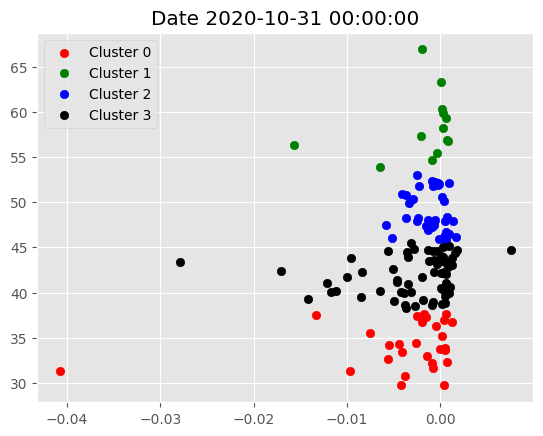

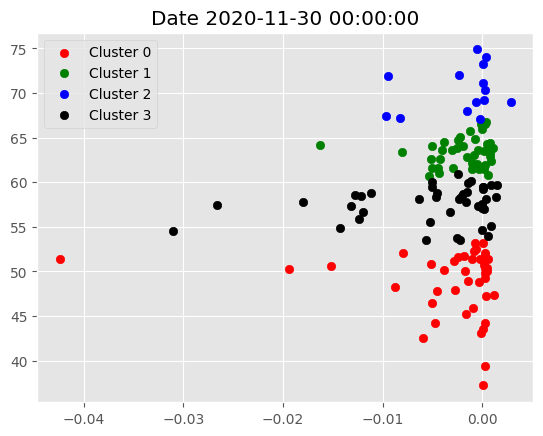

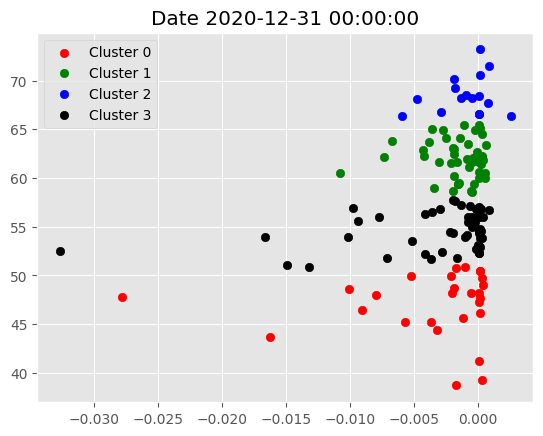

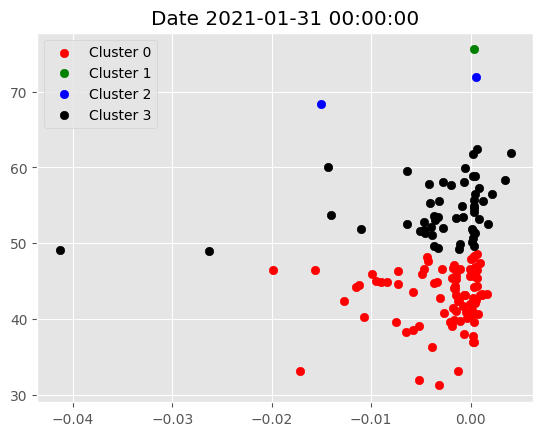

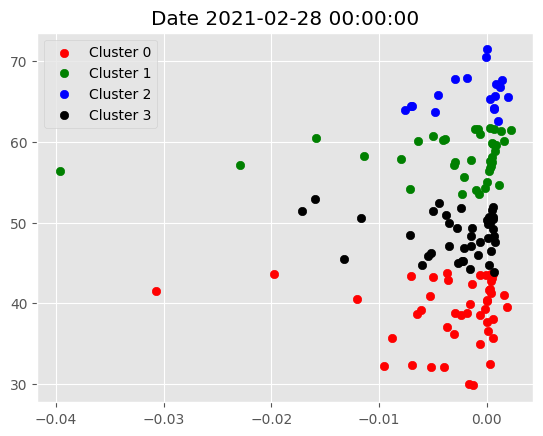

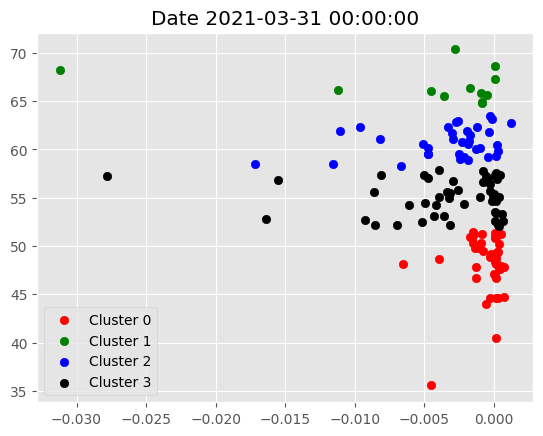

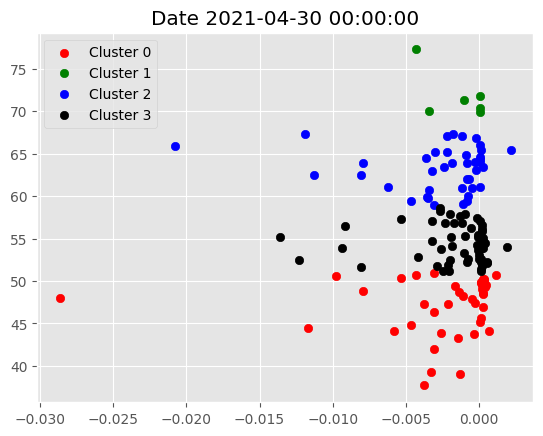

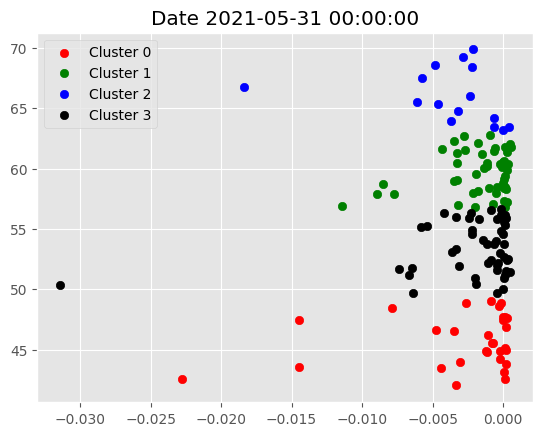

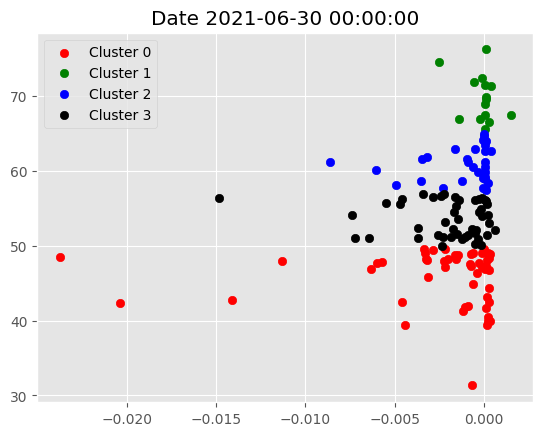

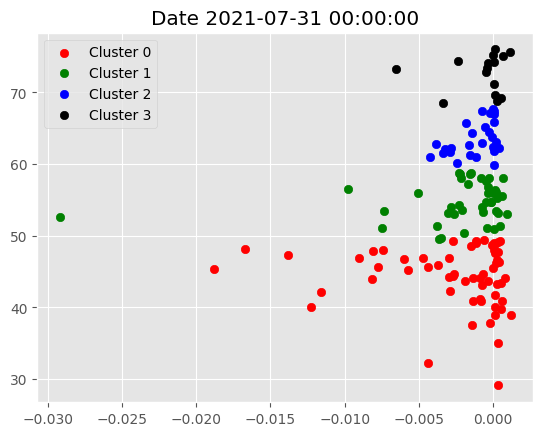

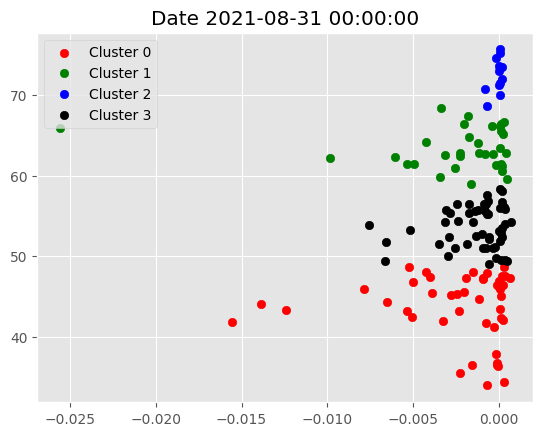

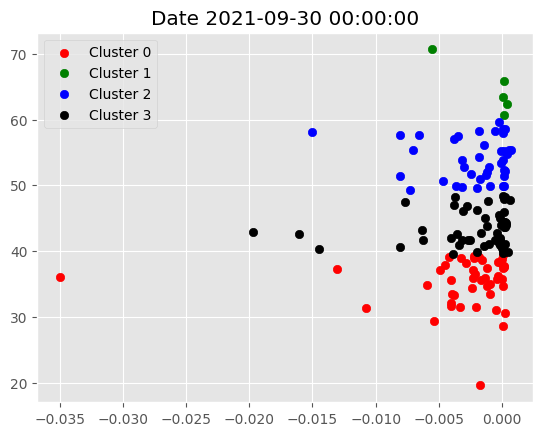

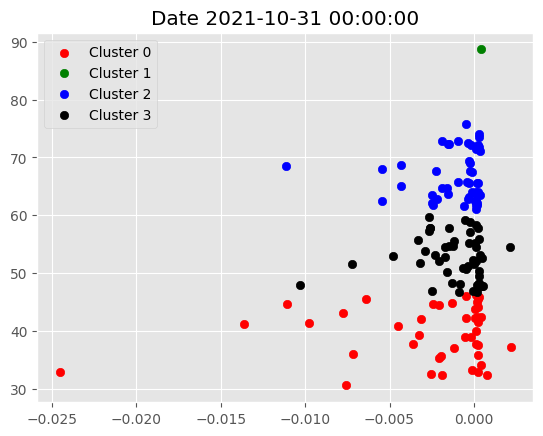

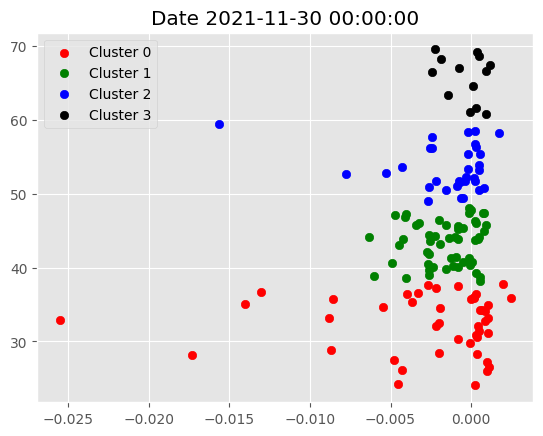

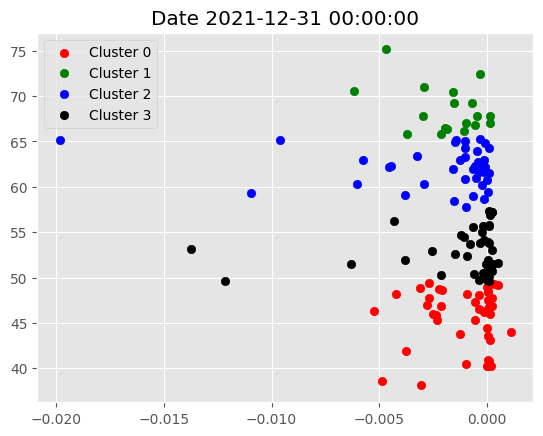

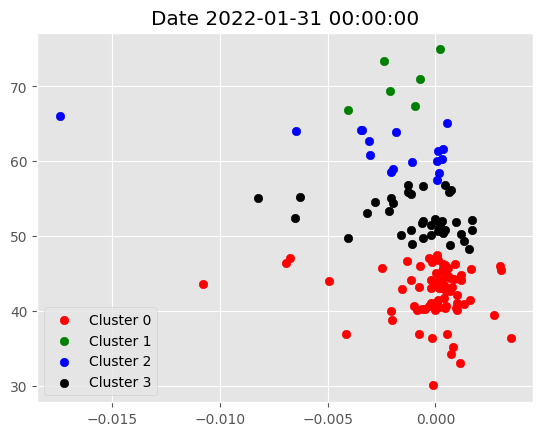

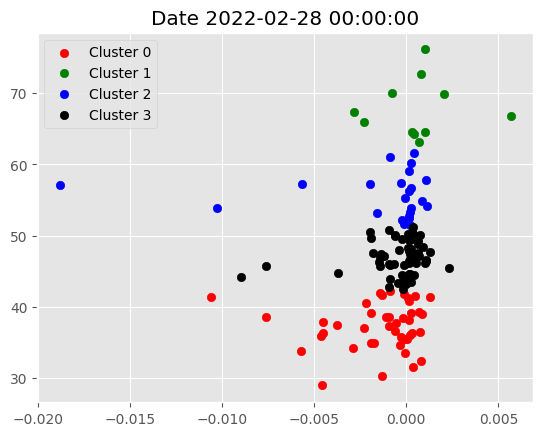

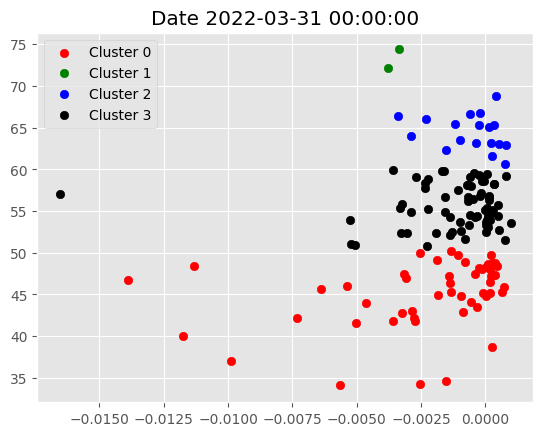

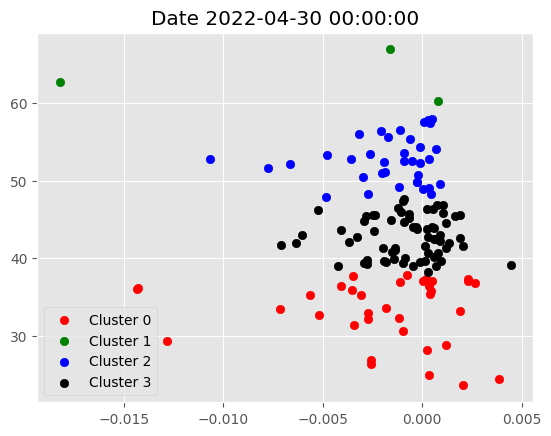

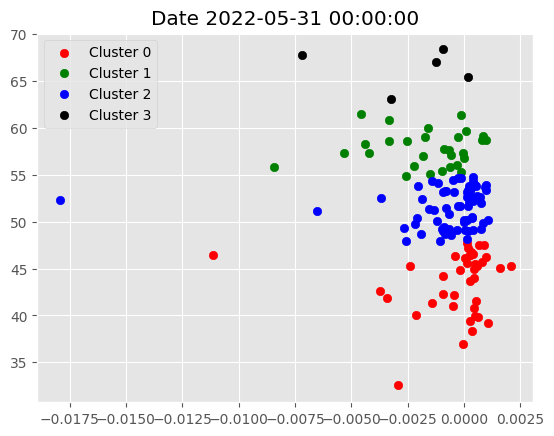

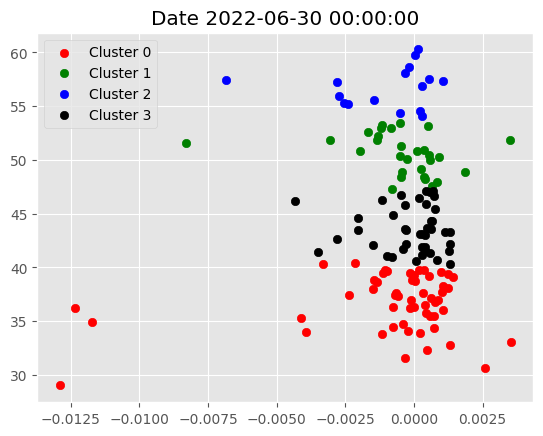

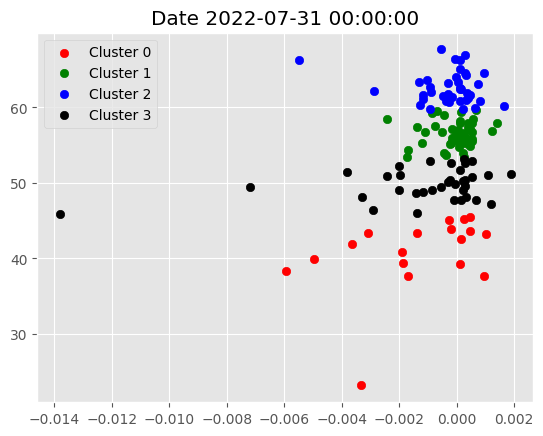

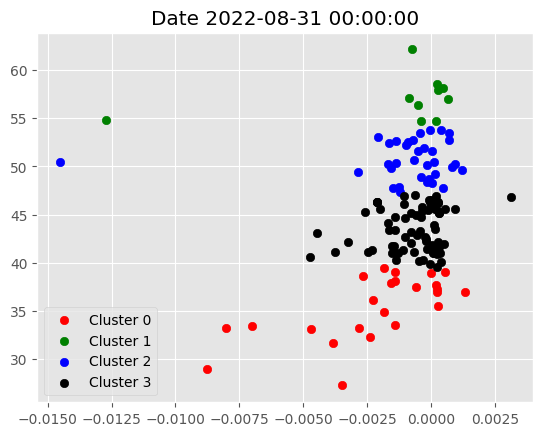

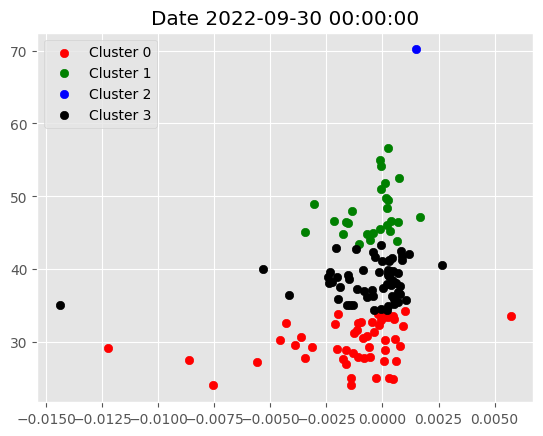

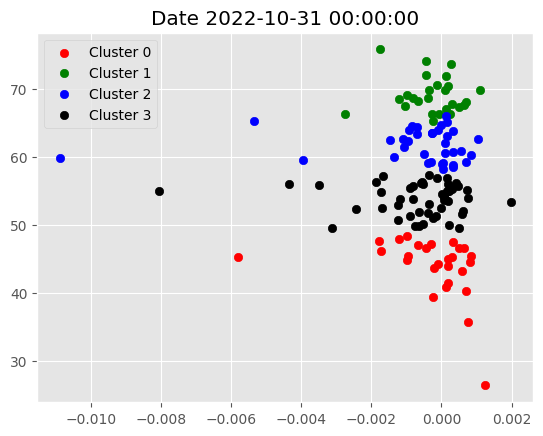

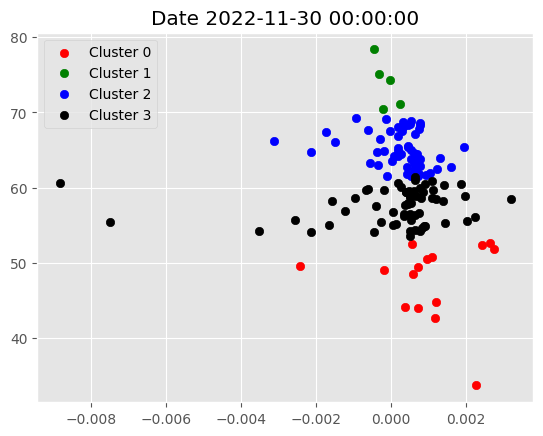

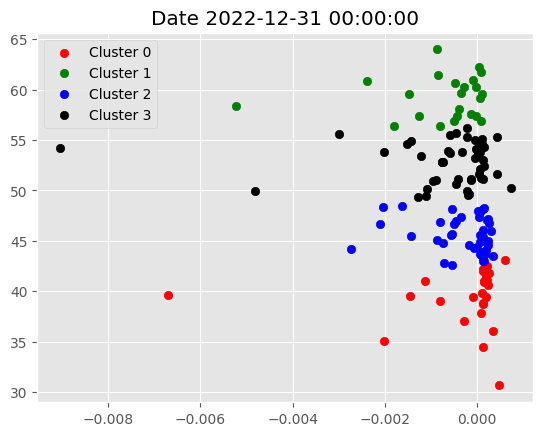

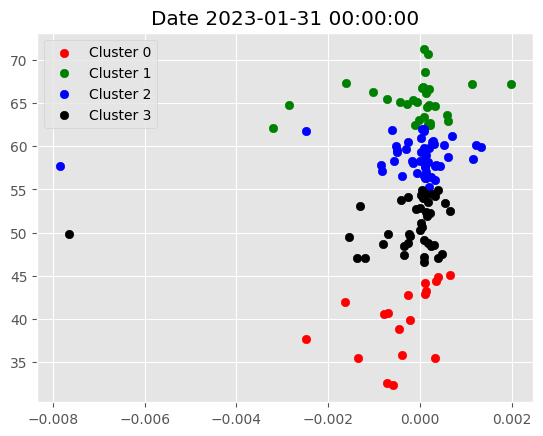

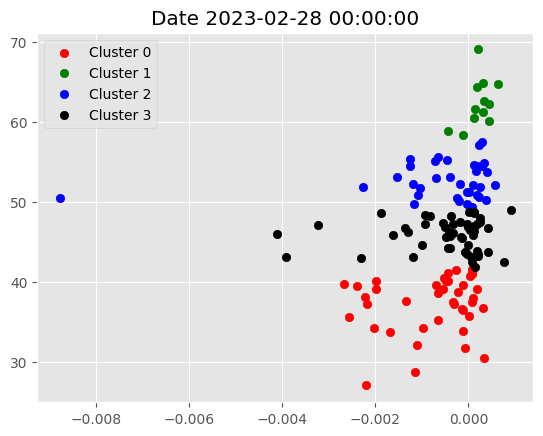

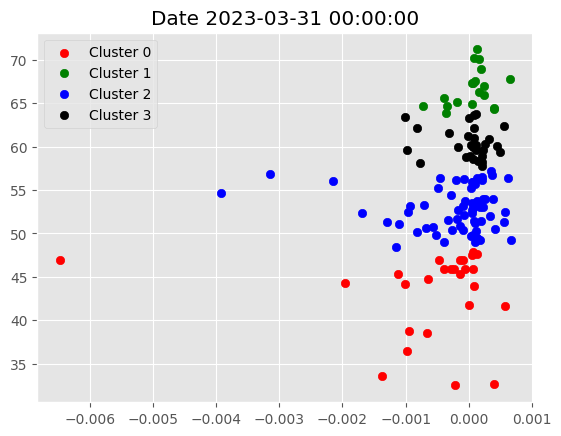

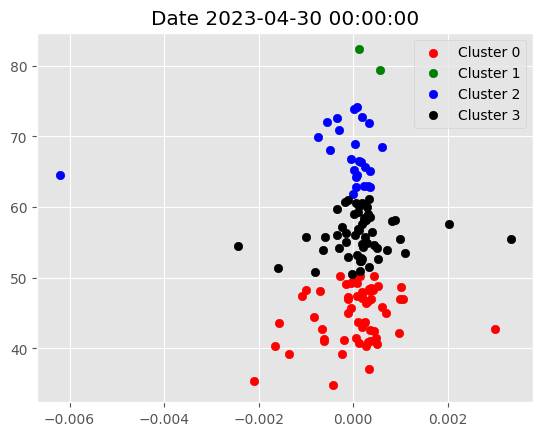

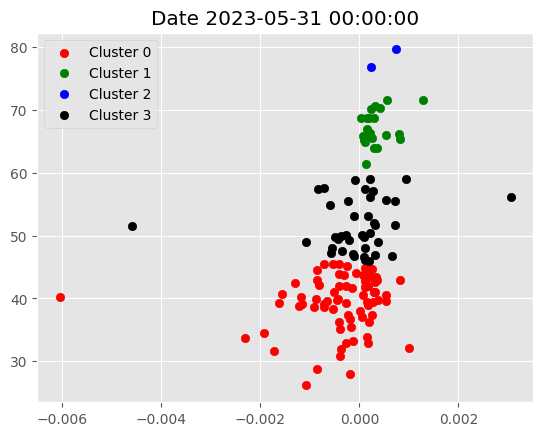

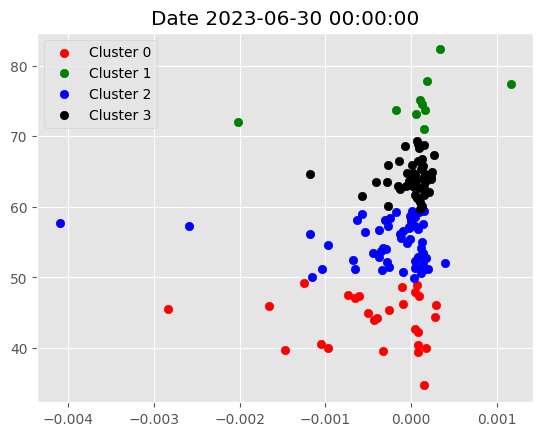

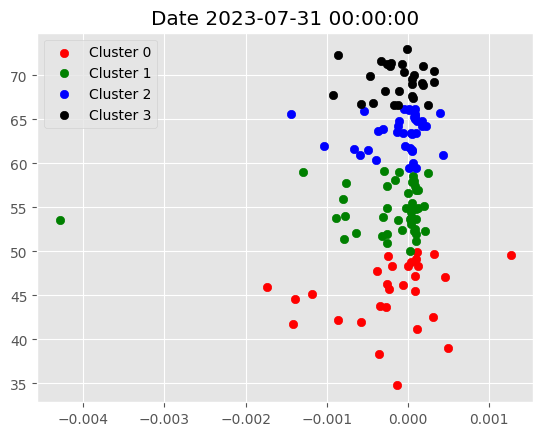

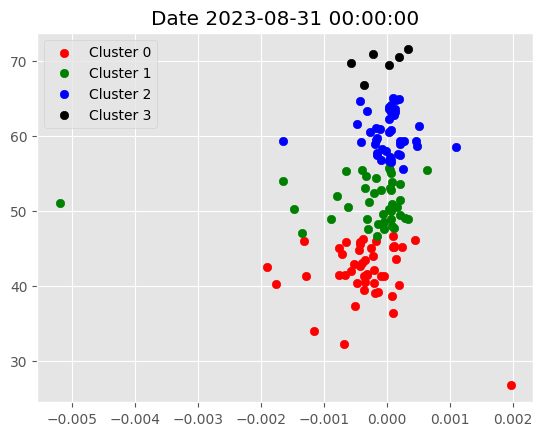

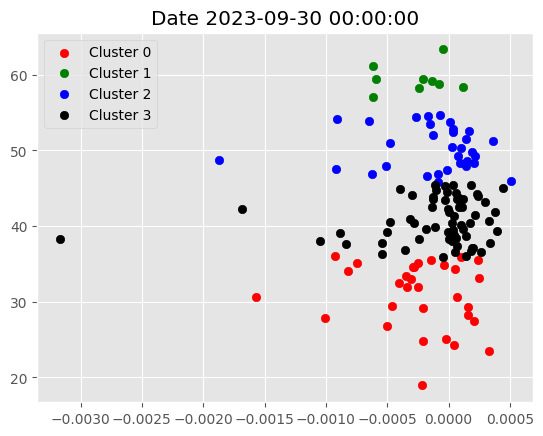

In [14]:
plt.style.use('ggplot')
def plot_clusters(g):
    cluster_0=g[g['cluster']==0]
    cluster_1=g[g['cluster']==1]    
    cluster_2=g[g['cluster']==2]
    cluster_3=g[g['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0],cluster_0.iloc[:,1],color='red',label='Cluster 0')
    plt.scatter(cluster_1.iloc[:,0],cluster_1.iloc[:,1],color='green',label='Cluster 1')
    plt.scatter(cluster_2.iloc[:,0],cluster_2.iloc[:,1],color='blue',label='Cluster 2')
    plt.scatter(cluster_3.iloc[:,0],cluster_3.iloc[:,1],color='black',label='Cluster 3')

    plt.legend()
    plt.show()

for i in data.index.get_level_values(0).unique().to_list():
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

### Select stocks based on the clustering

In [57]:
# filtered_df = data[data['cluster']==1].copy()
# filtered_df= filtered_df.reset_index(level=1)
# filtered_df.index += pd.DateOffset(days=1)
# filtered_df=filtered_df.reset_index().set_index(['date','ticker'])
# dates = filtered_df.index.get_level_values(0).unique().to_list()
# fixed_dates= {}
# for d in dates:
#     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,level=0).index.to_list()
# fixed_dates

{'2017-11-01': ['INTC', 'MSFT'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'MAR',
  'MMM',
  'NKE',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['AMZN'],
 '2018-03-01': ['AMD',
  'AVGO',
  'AXP',
  'C',
  'CAT',
  'CCL',
  'COP',
  'CSX',
  'DAL',
  'DD',
  'DE',
  'DG',
  'DHR',
  'ELV',
  'FCX',
  'FDX',
  'GILD',
  'GOOG',
  'GOOGL',
  'HON',
  'IBM',
  'KR',
  'LUV',
  'META',
  'MMM',
  'NEE',
  'ORLY',
  'PM',
  'QCOM',
  'SBUX',
  'SHW',
  'STZ',
  'T',
  'TMO',
  'UAL',
  'UNH',
  'UNP',
  'USB',
  'VLO',
  'WFC',
  'WYNN'],
 '2018-04-01': ['COP', 'INTC', 'NEE', 'PANW', 'STZ', 'WYNN'],
 '2018-05-01': ['CMG', 'EOG', 'HAL', 'OXY', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'BIIB',
  'CMG',
  'CSX

In [59]:
# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns

def optimize_weights(prices,lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS') 
    # weights = ef.max_sharpe()
    return ef.clean_weights()

#1:30
